# Getting Started

First, we'll take a look at CSR in a rectangular window.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [134]:
# Generates uniformly random points in a rectangular window from low to high
# low and high can be lists
def generateCSR(n=None, low=0.0, high=1.0):
    if not isinstance(low, np.ndarray):
        low = np.array(low)
        
    if not isinstance(high, np.ndarray):
        high = np.array(high)
        
    if len(low) != len(high):
        raise ValueError("generateCSR: Dimensionality of low and high must match")
    
    pts = np.random.uniform(size=(n, len(low))).reshape((n, len(low)))
    pts = pts  * (high-low) + low
    
    return pts

# Calculates distance matrix for list of points
# if flat is True, then returns list of upper triangle distances
# (1 unique number for each pair of points)
def distances(pts, flat=False):
    dists = np.expand_dims(pts, axis=0) - np.expand_dims(pts, axis=1)
    dists = np.sqrt(np.sum(dists ** 2, axis=-1))
    if flat:
        dists = dists[np.triu_indices(dists.shape[0], k=-1)]
    return dists

# Calculates CSR's theoretical value of K(t) for each provided
# value of t in ts.
def theoreticalK_CSR(ts):
    return np.pi * ts ** 2

# Estimates Ripley's edge correction by generating a circle of n points
# around the point li with radius r and returns the proportion of
# points which are inside the rectangle defined by the points low,high.
# Since this value is only 0 when n is too small, we iteratively double
# n until we detect more than 1 point inside the rectangle. This ensures
# that the returned value is within +- 1/n of the true edge correction.
def edgeCorrection(li, r, low, high, n=100):
    n_inside, n_iters = 0, 0
    while n_inside < 2 and n_iters < 10:
        thetas = np.linspace(0.0, 2 * np.pi, num=n)
        circle = np.array([np.cos(thetas), np.sin(thetas)]).T * r + li
        inside = np.all(circle > low, axis=1) & np.all(circle < high, axis=1)
        n_inside = np.sum(inside)
        n_iters += 1
        n *= 2
    return n_inside / n * 2

# Estimates K_hat(t) for each provided value of t in ts.
def empiricalK(pts, ts, bounds=None, edge_correction=True):
    if ts is None:
        raise ValueError("empiricalK: Must provide argument 'ts'")
    
    if not isinstance(ts, np.ndarray):
        ts = np.array(ts)
    
    if bounds is None:
        # If no bounds are provided, estimate it using the extents of the points
        low = pts.min(axis=0)
        high = pts.max(axis=0)
    else:
        low, high = bounds

    intensity = pts.shape[0] / np.product(high - low)
    
    if edge_correction == False:
        dists = distances(pts, flat=True)
        # Number of point pairs within distance t divided by number of points
        ks = np.array([(dists < t).sum()/pts.shape[0] for t in ts])
    else:
        dists = distances(pts)
        # Number of point pairs within distance t divided by number of points
        ks = np.zeros_like(ts)
        N = len(pts)
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                # Calculate the values of t which this pair is within
                ind = (ts > dists[i,j])
                if not np.any(ind):
                    continue

                # Calculate the edge correction weight and add to the running sum
                n = 200
                W_ij = edgeCorrection(pts[i], dists[i,j], low, high, n=n)
                while W_ij == 0.0:
                    # W_ij is only 0.0 when n was too small to detect the true value
                    # So we try again with twice the number of points
                    n = 2 * n
                    W_ij = edgeCorrection(pts[i], dists[i,j], low, high, n=n)
                ks += ind / W_ij
        ks /= N
    
    return ks / intensity

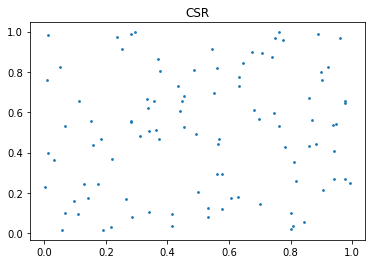

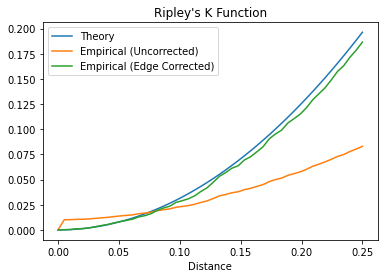

In [137]:
low, high = np.array([0.0, 0.0]), np.array([1.0,1.0])
pts = generateCSR(n=100, low=low, high=high)

plt.scatter(pts[:,0], pts[:,1], s=3)
plt.title("CSR")
plt.show()

ts = np.linspace(start=0.0, stop=0.25, num=50)
theory_K = theoreticalK_CSR(ts)
emp_k = empiricalK(pts, ts, bounds=(low,high), edge_correction=False)
emp_k_corrected = empiricalK(pts, ts, bounds=(low,high))

plt.plot(ts, theory_K, label="Theory")
plt.plot(ts, emp_k, label="Empirical (Uncorrected)")
plt.plot(ts, emp_k_corrected, label="Empirical (Edge Corrected)")
plt.title("Ripley's K Function")
plt.xlabel("Distance")
plt.legend()
plt.show()